In [1]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from collections import defaultdict
from pathlib import Path
from statistics import mean, stdev
from sklearn.metrics import ndcg_score, dcg_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source
from src.config import Config, get_option_fallback
from src.path import get_best_model_paths, get_exp_paths, get_report_path, load_json, load_rep_cfg, get_exp_names
from knowledge_tracing.trainer import Trainer

In [2]:
# projectdir = Path('/code')
projectdir = Path('..')
assert projectdir.exists()

# Common Functions

In [3]:
def summarize_test_res(rep, folds=5):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(folds)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(folds)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = pd.Series([rep['indicator']['test_auc'][str(i)][0] for i in range(folds)])
    print(f'Test AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['RPsoft']['all']
    print(f'Good:Bad = {s["good"]}:{s["bad"]}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'All Test AUC: {s*100:.4f}')

In [4]:
def show_valid_lc(name, idclist_dic, idc='eval_auc'):
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)

## Learning curve

In [65]:
def lc(config_name, objective='eval_auc', kfold=5, legend=False):
    # exp_names = ['ksvector_l10.auto', 'ksvector_l10.02.auto', 'ksvector_l150.auto']
    report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
    reports = [load_json(r) for r in report_paths]
    fig, ax = plt.subplots()
    for r in reports:
        x = []
        y = []
        for k in range(kfold):
            x += r['indicator']['epoch'][str(k)]
            y += r['indicator'][objective][str(k)]
        print(len(x), len(y))
        sns.lineplot(x, y, label=r['config']['exp_name'], ax=ax)
    if legend:
        ax.legend()

['ksvector_l150.auto', 'ksvector_l10.auto', 'ksvector_l10.02.auto']
250 250
520 520
430 430


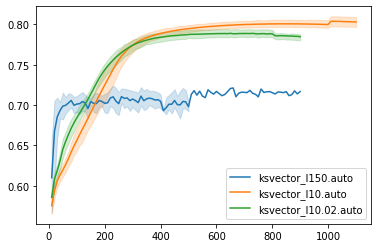

In [67]:
lc('20_0613_icce2020_assist09', legend=True)

In [68]:
lc('20_0613_icce2020_assist15')

TypeError: 'NoneType' object is not iterable

['ksvector_l150.auto', 'ksvector_l10.auto', 'ksvector_l10.02.auto']
40 40
170 170
140 140


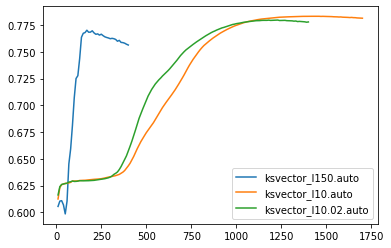

In [69]:
lc('20_0613_icce2020_synthetic', kfold=1)

['ksvector_l150.auto', 'ksvector_l10.auto', 'ksvector_l10.02.auto']
250 250
520 520
430 430


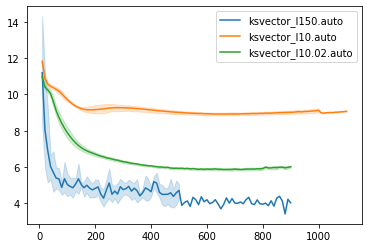

In [70]:
lc('20_0613_icce2020_assist09', objective='ksvector_l1')

In [71]:
lc('20_0613_icce2020_assist15', objective='ksvector_l1')

TypeError: 'NoneType' object is not iterable

['ksvector_l150.auto', 'ksvector_l10.auto', 'ksvector_l10.02.auto']
40 40
170 170
140 140


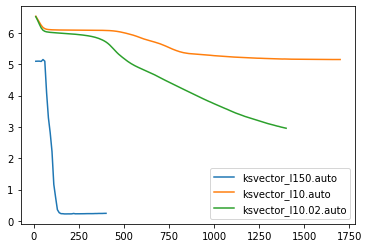

In [72]:
lc('20_0613_icce2020_synthetic', objective='ksvector_l1', kfold=1)

## AUC table

# Summary

In [75]:
def summarize_results(config_name, folds=5):
    report_list = []
    report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
    for r in report_paths:
        print(r)
    for r in [load_json(get_report_path(projectdir, config_name, e)) for e in get_exp_names(projectdir, config_name)]:
        report_list.append(r)
    df = pd.DataFrame(columns=[
        'dataset', 'model', 
        'best_auc', 'best_auc_std', 
        'ksv_loss',
        'w1', 'w2',
        'test_auc_c', 'test_auc_c_std', 
        'test_auc', 'test_auc_std', 
        'r1_good', 'r1_goodbad', 
        'r2', 'r2_std', 
    ])
    for r in sorted(report_list, key=lambda x: x['config']['ksvector_l1']):
        row = {}
        try:
            print([r['indicator']['test_auc'][str(i)][0] for i in range(folds)])
            row = {
                'dataset':   r['config']['config_name'],
                'model':     r['config']['exp_name'],
                'best_auc':       mean([r['best']['auc'][str(i)] for i in range(folds)]),
                'best_auc_std':   stdev([r['best']['auc'][str(i)] for i in range(folds)]) if folds > 1 else np.nan,
                'test_auc':       mean([r['indicator']['test_auc'][str(i)][0] for i in range(folds)]),
                'test_auc_std':   stdev([r['indicator']['test_auc'][str(i)][0] for i in range(folds)]) if folds > 1 else np.nan,
                'test_auc_c':       mean([r['indicator']['test_auc_c'][str(i)][0] for i in range(folds)]),
                'test_auc_c_std':   stdev([r['indicator']['test_auc_c'][str(i)][0] for i in range(folds)]) if folds > 1 else np.nan,
                'w1':   mean([r['indicator']['waviness_l1'][str(i)][-1] for i in range(folds)]),
                'w2':   mean([r['indicator']['waviness_l2'][str(i)][-1] for i in range(folds)]),
                'r1_good':       r['indicator']['RPsoft']['all']['good'],
                'r1_good':       r['indicator']['RPsoft']['all']['good'],
                'r1_goodbad':       r['indicator']['RPsoft']['all']['good'] + r['indicator']['RPsoft']['all']['bad'],
                'r2':      mean(r['indicator']['RPhard']['all']),
                'r2_std': stdev(r['indicator']['RPhard']['all'])
            }
            row['ksv_loss'] = mean([r['indicator']['ksvector_l1'][str(i)][-1] for i in range(folds)])
        except KeyError as e:
            print("KeyError:", e)
            row = {
                'dataset':   r['config']['config_name'],
                'model':     r['config']['exp_name'],
                **row
            }
        df = df.append(row, ignore_index=True)
    return df
        

In [76]:
summarize_results('20_0613_icce2020_assist09')

['ksvector_l150.auto', 'ksvector_l10.auto', 'ksvector_l10.02.auto']
../output/20_0613_icce2020_assist09/ksvector_l150.auto/report/20200613-0334/report.json
../output/20_0613_icce2020_assist09/ksvector_l10.auto/report/20200613-0202/report.json
../output/20_0613_icce2020_assist09/ksvector_l10.02.auto/report/20200613-0258/report.json
['ksvector_l150.auto', 'ksvector_l10.auto', 'ksvector_l10.02.auto']
[0.8026773880034015, 0.8040941836939841, 0.7993172898289018, 0.8010403788058595, 0.799952844199485]
[0.7877330858812511, 0.7851359715651939, 0.7899026452027595, 0.7905803521594201, 0.7875952836251661]
[0.7170668648896029, 0.7125486371746924, 0.7027784373728662, 0.7113120585150559, 0.7193891222939957]


,dataset,model,best_auc,best_auc_std,ksv_loss,w1,w2,test_auc_c,test_auc_c_std,test_auc,test_auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0613_icce2020_assist09,ksvector_l10.auto,0.801023,0.005873,9.160673,0.088652,0.027480,0.865576,0.003011,0.801416,0.001965,95,110,0.880344,0.127453
1,20_0613_icce2020_assist09,ksvector_l10.02.auto,0.789295,0.005950,5.938069,0.061624,0.015346,0.859745,0.006798,0.788189,0.002153,102,110,0.954068,0.080994
2,20_0613_icce2020_assist09,ksvector_l150.auto,0.713248,0.012143,4.858845,0.038914,0.008978,0.853101,0.009671,0.712619,0.006406,104,110,0.977960,0.068384


In [77]:
summarize_results('20_0613_icce2020_synthetic', 1)

['ksvector_l150.auto', 'ksvector_l10.auto', 'ksvector_l10.02.auto']
../output/20_0613_icce2020_synthetic/ksvector_l150.auto/report/20200613-0135/report.json
../output/20_0613_icce2020_synthetic/ksvector_l10.auto/report/20200613-0117/report.json
../output/20_0613_icce2020_synthetic/ksvector_l10.02.auto/report/20200613-0127/report.json
['ksvector_l150.auto', 'ksvector_l10.auto', 'ksvector_l10.02.auto']
[0.7774484041386555]
[0.7736595195175596]
[0.7645667583023271]


,dataset,model,best_auc,best_auc_std,ksv_loss,w1,w2,test_auc_c,test_auc_c_std,test_auc,test_auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0613_icce2020_synthetic,ksvector_l10.auto,0.783190,NaN,5.155035,0.036524,0.003177,0.589763,NaN,0.777448,NaN,27,50,0.796846,0.129538
1,20_0613_icce2020_synthetic,ksvector_l10.02.auto,0.779613,NaN,2.958468,0.032774,0.002700,0.584255,NaN,0.773660,NaN,36,50,0.886422,0.133569
2,20_0613_icce2020_synthetic,ksvector_l150.auto,0.770124,NaN,0.238449,0.093327,0.053591,0.582725,NaN,0.764567,NaN,41,50,0.906860,0.113980


In [14]:
summarize_results('20_0605_icce2020_assist15')

['reconstruction_and_wavinessFalseksvector_l10.0.auto', 'reconstruction_and_wavinessTrueksvector_l10.0.auto', 'reconstruction_and_wavinessFalseksvector_l10.001.auto', 'reconstruction_and_wavinessTrueksvector_l10.001.auto']
../output/20_0605_icce2020_assist15/reconstruction_and_wavinessFalseksvector_l10.0.auto/report/20200605-1917/report.json
../output/20_0605_icce2020_assist15/reconstruction_and_wavinessTrueksvector_l10.0.auto/report/20200605-1801/report.json
../output/20_0605_icce2020_assist15/reconstruction_and_wavinessFalseksvector_l10.001.auto/report/20200605-1645/report.json
../output/20_0605_icce2020_assist15/reconstruction_and_wavinessTrueksvector_l10.001.auto/report/20200605-2033/report.json
['reconstruction_and_wavinessFalseksvector_l10.0.auto', 'reconstruction_and_wavinessTrueksvector_l10.0.auto', 'reconstruction_and_wavinessFalseksvector_l10.001.auto', 'reconstruction_and_wavinessTrueksvector_l10.001.auto']
[0.6938559928063119, 0.6948579558580857, 0.6933676859014026, 0.69500

,dataset,model,best_auc,best_auc_std,test_auc,test_auc_std,r1_good,r1_goodbad,r2,r2_std,w1,w2,ksv_loss
0,20_0605_icce2020_assist15,reconstruction_and_wavinessFalseksvector_l10.0.auto,0.694035,0.003051,0.694269,0.000684,100,100,0.947281,0.084908,0.045937,0.005480,8.724243
1,20_0605_icce2020_assist15,reconstruction_and_wavinessTrueksvector_l10.0.auto,0.694035,0.003051,0.694269,0.000684,100,100,0.947281,0.084908,0.045937,0.005480,8.724243
2,20_0605_icce2020_assist15,reconstruction_and_wavinessFalseksvector_l10.001.auto,0.694388,0.003087,0.694642,0.000664,100,100,0.952202,0.079391,0.045371,0.005373,8.448690
3,20_0605_icce2020_assist15,reconstruction_and_wavinessTrueksvector_l10.001.auto,0.694388,0.003087,0.694642,0.000664,100,100,0.952202,0.079391,0.045371,0.005373,8.448690


In [15]:
summarize_results('20_0605_icce2020_statics')

['reconstruction_and_wavinessFalseksvector_l10.0.auto', 'reconstruction_and_wavinessTrueksvector_l10.0.auto', 'reconstruction_and_wavinessFalseksvector_l10.001.auto', 'reconstruction_and_wavinessTrueksvector_l10.001.auto']
../output/20_0605_icce2020_statics/reconstruction_and_wavinessFalseksvector_l10.0.auto/report/20200610-0812/report.json
../output/20_0605_icce2020_statics/reconstruction_and_wavinessTrueksvector_l10.0.auto/report/20200609-2327/report.json
../output/20_0605_icce2020_statics/reconstruction_and_wavinessFalseksvector_l10.001.auto/report/20200610-1311/report.json
../output/20_0605_icce2020_statics/reconstruction_and_wavinessTrueksvector_l10.001.auto/report/20200610-0421/report.json
['reconstruction_and_wavinessFalseksvector_l10.0.auto', 'reconstruction_and_wavinessTrueksvector_l10.0.auto', 'reconstruction_and_wavinessFalseksvector_l10.001.auto', 'reconstruction_and_wavinessTrueksvector_l10.001.auto']
[0.7710669042356004, 0.7733237123271862, 0.7693805999491921, 0.768775776

,dataset,model,best_auc,best_auc_std,test_auc,test_auc_std,r1_good,r1_goodbad,r2,r2_std,w1,w2,ksv_loss
0,20_0605_icce2020_statics,reconstruction_and_wavinessFalseksvector_l10.0.auto,0.765353,0.003810,0.770940,0.001889,640,1223,0.808045,0.140852,0.018172,0.000723,3.928196
1,20_0605_icce2020_statics,reconstruction_and_wavinessTrueksvector_l10.0.auto,0.765353,0.003810,0.770940,0.001889,640,1223,0.808045,0.140852,0.018172,0.000723,3.928196
2,20_0605_icce2020_statics,reconstruction_and_wavinessFalseksvector_l10.001.auto,0.761572,0.011431,0.767858,0.009253,672,1223,0.813156,0.142237,0.014875,0.000560,3.950800
3,20_0605_icce2020_statics,reconstruction_and_wavinessTrueksvector_l10.001.auto,0.761572,0.011431,0.767858,0.009253,672,1223,0.813156,0.142240,0.014875,0.000560,3.950800


In [16]:
summarize_results('20_0605_icce2020_synthetic', 1)

['reconstruction_and_wavinessFalseksvector_l10.0.auto', 'reconstruction_and_wavinessTrueksvector_l10.0.auto', 'reconstruction_and_wavinessFalseksvector_l10.001.auto', 'reconstruction_and_wavinessTrueksvector_l10.001.auto']
../output/20_0605_icce2020_synthetic/reconstruction_and_wavinessFalseksvector_l10.0.auto/report/20200609-2253/report.json
../output/20_0605_icce2020_synthetic/reconstruction_and_wavinessTrueksvector_l10.0.auto/report/20200609-2242/report.json
../output/20_0605_icce2020_synthetic/reconstruction_and_wavinessFalseksvector_l10.001.auto/report/20200609-2259/report.json
../output/20_0605_icce2020_synthetic/reconstruction_and_wavinessTrueksvector_l10.001.auto/report/20200609-2247/report.json
['reconstruction_and_wavinessFalseksvector_l10.0.auto', 'reconstruction_and_wavinessTrueksvector_l10.0.auto', 'reconstruction_and_wavinessFalseksvector_l10.001.auto', 'reconstruction_and_wavinessTrueksvector_l10.001.auto']
[0.6820511468451309]
[0.6820497783253608]
[0.6824100823151777]
[

,dataset,model,best_auc,best_auc_std,test_auc,test_auc_std,r1_good,r1_goodbad,r2,r2_std,w1,w2,ksv_loss
0,20_0605_icce2020_synthetic,reconstruction_and_wavinessFalseksvector_l10.0.auto,0.689745,NaN,0.682051,NaN,28,50,0.818750,0.139029,0.029942,0.003236,5.276833
1,20_0605_icce2020_synthetic,reconstruction_and_wavinessTrueksvector_l10.0.auto,0.689744,NaN,0.682050,NaN,28,50,0.818750,0.139029,0.029942,0.003236,5.276833
2,20_0605_icce2020_synthetic,reconstruction_and_wavinessFalseksvector_l10.001.auto,0.690064,NaN,0.682410,NaN,28,50,0.828141,0.142961,0.029709,0.003226,5.177509
3,20_0605_icce2020_synthetic,reconstruction_and_wavinessTrueksvector_l10.001.auto,0.690068,NaN,0.682412,NaN,28,50,0.828141,0.142961,0.029709,0.003226,5.177509


In [11]:
print(summarize_results('20_0310_edm2020_assist09').to_latex())
print(summarize_results('20_0310_edm2020_assist15').to_latex())
print(summarize_results('20_0310_edm2020_synthetic', folds=1).to_latex())
print(summarize_results('20_0310_edm2020_statics').to_latex())

['pre_dummy_epoch_size150.auto', 'pre_dummy_epoch_size10.auto', 'pre_dummy_epoch_size0.auto']
../output/20_0310_edm2020_assist09/pre_dummy_epoch_size150.auto/report/20200310-0014/report.json
../output/20_0310_edm2020_assist09/pre_dummy_epoch_size10.auto/report/20200309-2301/report.json
../output/20_0310_edm2020_assist09/pre_dummy_epoch_size0.auto/report/20200309-2154/report.json
['pre_dummy_epoch_size150.auto', 'pre_dummy_epoch_size10.auto', 'pre_dummy_epoch_size0.auto']
[0.8046503049499316, 0.8049546286277647, 0.804994971543892, 0.8057559810031332, 0.8066320973895094]
[0.8037119064114193, 0.801649358931628, 0.8015641276083421, 0.8038862650589503, 0.8030035397822728]
[0.8032588441833508, 0.8041532123681269, 0.7987161988205331, 0.8033092169297742, 0.8025557373590517]
\begin{tabular}{lllrrrrllrrrrr}
\toprule
{} &                   dataset &                         model &  best\_auc &  best\_auc\_std &  test\_auc &  test\_auc\_std & r1\_good & r1\_goodbad &        r2 &    r2\_std &      

## NDCG distplot

In [12]:
def ndcg_distplot(config_name, bins=20):
    report_list = []
    for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
        if r['config']['pre_dummy_epoch_size'] not in {0, 10}:
            continue
        r['config']['exp_name'] = f"DKT pre {r['config']['pre_dummy_epoch_size']}"
        report_list.append(r)
    for rep in report_list:
        r = rep['indicator']['RPhard']['all']
        name = rep['config']['exp_name']
        sns.distplot(r, bins=bins, label=name, kde_kws={'clip': (0.0, 1.0)})
    plt.legend()
    plt.xlabel('NDCG distribution')
    plt.ylabel('frequency')
    plt.title(config_name)
    plt.show()

In [13]:
ndcg_distplot('20_0310_edm2020_assist09')
ndcg_distplot('20_0310_edm2020_assist15')
ndcg_distplot('20_0310_edm2020_synthetic')
ndcg_distplot('20_0310_edm2020_statics')

TypeError: get_report_path() missing 1 required positional argument: 'exp_name'

## Learning curve

In [ ]:
def lc_plot(config_name):
    report_list = []
    for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
        if r['config']['pre_dummy_epoch_size'] not in {0, 10}:
            continue
        r['config']['exp_name'] = f"DKT pre {r['config']['pre_dummy_epoch_size']}"
        report_list.append(r)
    for r in report_list:
#         show_valid_lc(r['config']['exp_name'], r['indicator'])
        idclist_dic = r['indicator']
        idc = 'eval_auc'
        min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
        x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
        y = []
        for _y in idclist_dic[idc].values():
            y += _y[:min_len]
        sns.lineplot(x=x, y=y, label=r['config']['exp_name'], ci='sd')
    plt.title(config_name)
    plt.xlabel('epoch')
    plt.ylabel('AUC')
    plt.show()

In [ ]:
lc_plot('20_0310_edm2020_assist09')
lc_plot('20_0310_edm2020_assist15')
lc_plot('20_0310_edm2020_synthetic')
lc_plot('20_0310_edm2020_statics')

# `20_0310_edm2020_assist09`

## Simulated curve

In [ ]:
config_name = '20_0310_edm2020_assist09'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    if r['config']['pre_dummy_epoch_size'] not in {0, 10}:
        continue
    r['config']['exp_name'] = f"DKT pre {r['config']['pre_dummy_epoch_size']}"
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

In [ ]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

In [ ]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{}'.format(v))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## Single ones

In [ ]:
def plot_single(kc):
    x, y = base_res[str(kc)]
    sns.lineplot(x=x, y=y)
plot_single(78)

In [ ]:
f, axs = plt.subplots(1, 3, sharey=True, figsize=(12,3))
f.tight_layout()
for i, (kc, ax) in enumerate(zip([30, 83, 98], axs)):
    ax.set_ylim([0, 1])
    x, y = base_res[str(kc)]
    sns.lineplot(x=x, y=y, ax=ax)
    ax.set_title(f'KC{kc}')
    ax.set_ylabel('predicted accuracy')
    ax.set_xlabel('$k$\n({})'.format(['a','b','c'][i]))
plt.show()

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

## Learning curve

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()

## Test AUC

In [ ]:
for r in report_list:
    summarize_test_res(r)

# `Debug`

## Simulated curve

In [ ]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Test AUC

## Simulated curve

In [ ]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']


simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    

base_idx = 1
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

## Learning curve

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Test AUC

In [ ]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(5)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(5)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'Test AUC: {s*100:.4f}')

In [ ]:
for r in report_list:
    summarize_test_res(r)

# `20_0310_edm2020_synthetic`

## Simulated curve

In [ ]:
config_name = '20_0310_edm2020_synthetic'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

In [ ]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

In [ ]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]>sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

## Learning curve

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Test AUC

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
    summarize_test_res(r, folds=1)
plt.show()

## Test AUC

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Learning curve

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

# `20_0310_edm2020_assist15`

## Simulated curve

In [ ]:
config_name = '20_0310_edm2020_assist15'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

In [ ]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

In [ ]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]>sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=20, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

## Learning curve AUC

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
    summarize_test_res(r)
plt.show()

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()